
# Experiment 3 — LoRA Adapters + Bayesian Approximation (Laplace/Fisher) for 3‑way MCQ

**Goal.** Start from a small pretrained text encoder, add **LoRA adapters** to a few attention/projection modules, fine‑tune only those adapters on a **3‑option multiple‑choice** task, then place a **Bayesian posterior** over the *adapter parameters* using a simple **diagonal Laplace / Fisher approximation**.

**Why this is nice (for education + speed):**
- We avoid sampling full Transformer weights. We only adapt a tiny set of parameters (LoRA).
- After fine‑tuning, we build a Gaussian posterior around the MAP solution using the **empirical Fisher diagonal** (i.e., squared gradients under the data).
- Posterior predictive = **Monte Carlo average** over a few draws of adapter weights.
- We can then plot the same **calibration** and **abstention** figures as in the previous experiments.



## 0) Setup

Install (inside your Pipenv or environment):
```bash
pipenv run pip install "torch>=2.2" transformers peft accelerate datasets     scikit-learn pandas matplotlib numpy tqdm
```
> On Apple Silicon without GPU, this runs on CPU and is fine for small models.



## 1) Data — 3‑option MCQ
Expecting a pandas DataFrame `df` with columns:
- `question`, `option_a`, `option_b`, `option_c`, `label` (0,1,2)

Below we create a small default dataset if `df` is not defined yet.


In [108]:

import pandas as pd

if 'df' not in globals():
    rows = [
        # label 0
        {"question": "Which planet is known as the Red Planet?", "option_a": "Mars", "option_b": "Venus", "option_c": "Jupiter", "label": 0},
        {"question": "Capital of France?", "option_a": "Paris", "option_b": "Berlin", "option_c": "Madrid", "label": 0},
        {"question": "Which animal barks?", "option_a": "dog", "option_b": "cat", "option_c": "cow", "label": 0},
        {"question": "Which country hosted the 2016 Summer Olympics?", "option_a": "Brazil", "option_b": "China", "option_c": "UK", "label": 0},
        {"question": "Who discovered penicillin?", "option_a": "Alexander Fleming", "option_b": "Marie Curie", "option_c": "Louis Pasteur", "label": 0},
        {"question": "What is the capital of Japan?", "option_a": "Kyoto", "option_b": "Tokyo", "option_c": "Osaka", "label": 0},
        {"question": "Which is the fastest land animal?", "option_a": "Cheetah", "option_b": "Horse", "option_c": "Lion", "label": 0},
        {"question": "Who wrote 'Romeo and Juliet'?", "option_a": "William Shakespeare", "option_b": "Charles Dickens", "option_c": "Mark Twain", "label": 0},
        {"question": "Which gas is essential for respiration?", "option_a": "Oxygen", "option_b": "Carbon monoxide", "option_c": "Helium", "label": 0},
        {"question": "Which continent is Egypt located in?", "option_a": "Africa", "option_b": "Asia", "option_c": "Europe", "label": 0},
        # label 1
        {"question": "What color are bananas when ripe?", "option_a": "red", "option_b": "yellow", "option_c": "blue", "label": 1},
        {"question": "How many continents are there?", "option_a": "Five", "option_b": "Seven", "option_c": "Six", "label": 1},
        {"question": "Who painted the Mona Lisa?", "option_a": "Michelangelo", "option_b": "Leonardo da Vinci", "option_c": "Raphael", "label": 1},
        {"question": "What is the boiling point of water at sea level (°C)?", "option_a": "90", "option_b": "100", "option_c": "110", "label": 1},
        {"question": "2 + 2 equals?", "option_a": "3", "option_b": "4", "option_c": "5", "label": 1},
        {"question": "How many players are on a standard soccer team (on field)?", "option_a": "9", "option_b": "11", "option_c": "12", "label": 1},
        {"question": "Which element has the symbol 'O'?", "option_a": "Osmium", "option_b": "Oxygen", "option_c": "Gold", "label": 1},
        {"question": "Which shape has three sides?", "option_a": "Square", "option_b": "Triangle", "option_c": "Pentagon", "label": 1},
        {"question": "What is the largest mammal?", "option_a": "Elephant", "option_b": "Blue Whale", "option_c": "Giraffe", "label": 1},
        {"question": "Which ocean is the largest?", "option_a": "Pacific Ocean", "option_b": "Atlantic Ocean", "option_c": "Indian Ocean", "label": 1},
        # label 2
        {"question": "Which organ pumps blood in the human body?", "option_a": "Lungs", "option_b": "Brain", "option_c": "Heart", "label": 2},
        {"question": "The Sun is a ...", "option_a": "planet", "option_b": "comet", "option_c": "star", "label": 2},
        {"question": "Which metal is liquid at room temperature?", "option_a": "Mercury", "option_b": "Iron", "option_c": "Aluminum", "label": 2},
        {"question": "The Great Wall is located in which country?", "option_a": "India", "option_b": "China", "option_c": "Japan", "label": 2},
        {"question": "Which planet has the most moons?", "option_a": "Jupiter", "option_b": "Saturn", "option_c": "Neptune", "label": 2},
        {"question": "Which gas do humans exhale?", "option_a": "Oxygen", "option_b": "Carbon dioxide", "option_c": "Nitrogen", "label": 2},
        {"question": "Which city is known as the Big Apple?", "option_a": "New York", "option_b": "Los Angeles", "option_c": "Chicago", "label": 0},
        {"question": "Which country is both in Europe and Asia?", "option_a": "Turkey", "option_b": "Spain", "option_c": "Mexico", "label": 0},
        {"question": "Which month has 28 days?", "option_a": "February", "option_b": "June", "option_c": "November", "label": 0},
        {"question": "What is the chemical symbol for gold?", "option_a": "Ag", "option_b": "Au", "option_c": "Pb", "label": 1},
    ]
    df = pd.DataFrame(rows)

df.head()


,question,option_a,option_b,option_c,label
0,Which planet is known as the Red Planet?,Mars,Venus,Jupiter,0
1,Capital of France?,Paris,Berlin,Madrid,0
2,Which animal barks?,dog,cat,cow,0
3,Which country hosted the 2016 Summer Olympics?,Brazil,China,UK,0
4,Who discovered penicillin?,Alexander Fleming,Marie Curie,Louis Pasteur,0



## 2) Split


In [109]:

from sklearn.model_selection import train_test_split
import numpy as np

y = df['label'].values.astype(int)
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42, stratify=y if len(np.unique(y))>1 else None)
len(train_df), len(test_df)


(18, 12)


## 3) Model — Tiny encoder + LoRA adapters

We use a **very small** encoder to keep it fast (e.g., `prajjwal1/bert-tiny`). We score each (question, option) pair separately, then **softmax across the 3 options**.


In [137]:

import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
from peft import LoraConfig, get_peft_model, TaskType

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_name = "prajjwal1/bert-tiny"  # small & fast
#model_name = "microsoft/MiniLM-L12-H384-uncased"
model_name = "prajjwal1/bert-small"

tok = AutoTokenizer.from_pretrained(model_name)
base = AutoModel.from_pretrained(model_name).to(device)
base.eval()

# Freeze base model
for p in base.parameters():
    p.requires_grad_(False)

# Attach LoRA to attention projections (keys vary by model; this works for BERT-like)
lora_cfg = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=16,              # was 8
    lora_alpha=32,     # scale with r
    lora_dropout=0.05,
    target_modules=["query", "key", "value", "dense"],
    bias="none",
)
base_lora = get_peft_model(base, lora_cfg).to(device)
base_lora.train()

# Lightweight classification head on top of [CLS]
hidden = base.config.hidden_size
head = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(base.config.hidden_size, 1, bias=True)
).to(device)
# nn.init.zeros_(head.bias)



## 4) Dataloaders — turn MCQ into pairwise inputs

Each example yields 3 encodings: (question, option_a/b/c) → we get [CLS] and score each separately.


In [138]:
def collate(batch):
    """
    batch: list of tuples (question: str, options: List[str], label: int)

    Returns:
      enc       : dict of tokenized tensors (B_pairs, T)
      map_idx   : tensor of item indices (len = B_pairs)
      opt_pos   : tensor of option indices (len = B_pairs)
      labels    : tensor of gold labels (len = N_items)
    """
    qs, opts_list, labels = zip(*batch)   # unpack the batch
    pairs_q, pairs_a, map_idx, opt_pos = [], [], [], []

    for i, (q, opts) in enumerate(zip(qs, opts_list)):
        for j, a in enumerate(opts):
            pairs_q.append(q)
            pairs_a.append(a)
            map_idx.append(i)
            opt_pos.append(j)

    enc = tok(
        pairs_q, pairs_a,
        padding=True, truncation=True, max_length=128,
        return_tensors="pt"
    ).to(device)

    return (
        enc,
        torch.tensor(map_idx, dtype=torch.long, device=device),
        torch.tensor(opt_pos, dtype=torch.long, device=device),
        torch.tensor(labels, dtype=torch.long, device=device),
    )

In [139]:
# ==== Load CommonsenseQA and build DataLoaders (N-choice) ====

# pip install -q datasets  # run once if you don't have it
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import random

# Reproducibility
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# 1) Load the dataset (train/validation/test)
csqa = load_dataset("commonsense_qa")
print(csqa)  # shows split sizes

# 2) Adapter: return (question: str, options: List[str], label: int)
class CommonsenseQADataset(Dataset):
    def __init__(self, hf_split):
        self.data = hf_split
    def __len__(self): 
        return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[idx]
        q = ex["question"]
        opts = ex["choices"]["text"]           # list of 5 strings
        # map answerKey (e.g., "A") -> index 0..4 using choices["label"]
        label_letters = ex["choices"]["label"] # e.g., ['A','B','C','D','E']
        y = label_letters.index(ex["answerKey"])
        return q, opts, y

train_ds = CommonsenseQADataset(csqa["train"])
val_ds   = CommonsenseQADataset(csqa["validation"])   # use as test for quick experiments
# test_ds = CommonsenseQADataset(csqa["test"])        # labels held out for official test

# 3) Quick subsetting knob (optional for fast iteration on CPU)
#    Comment these lines to use the full splits.
MAX_TRAIN = 2000   # e.g., 2k train for speed; set None for full
MAX_VAL   = 500
if MAX_TRAIN is not None:
    train_ds = torch.utils.data.Subset(train_ds, list(range(min(MAX_TRAIN, len(train_ds)))))
if MAX_VAL is not None:
    val_ds   = torch.utils.data.Subset(val_ds,   list(range(min(MAX_VAL,   len(val_ds)))))

# 4) DataLoaders — reuse your N-choice collate() and global tok/device
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_VAL   = 32

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
    collate_fn=collate, num_workers=0, pin_memory=False
)
test_loader = DataLoader(
    val_ds,   batch_size=BATCH_SIZE_VAL,   shuffle=False,
    collate_fn=collate, num_workers=0, pin_memory=False
)

# 5) Sanity check — one mini-batch
enc, map_idx, opt_pos, labels = next(iter(train_loader))
print("enc keys:", list(enc.keys()))
print("pairs:", enc["input_ids"].shape[0], "| items:", labels.shape[0], "| options per item (should be 5):", int(opt_pos.max().item())+1)

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'question_concept', 'choices', 'answerKey'],
        num_rows: 9741
    })
    validation: Dataset({
        features: ['id', 'question', 'question_concept', 'choices', 'answerKey'],
        num_rows: 1221
    })
    test: Dataset({
        features: ['id', 'question', 'question_concept', 'choices', 'answerKey'],
        num_rows: 1140
    })
})
enc keys: ['input_ids', 'token_type_ids', 'attention_mask']
pairs: 80 | items: 16 | options per item (should be 5): 5



## 5) Fine‑tune LoRA adapters (MAP estimate)

We optimize only **LoRA adapter params** and the **linear head**, with cross‑entropy over the 3 options.


In [121]:
def regroup_scores(scores_flat, map_idx, opt_pos, num_items, num_classes):
    """
    scores_flat: (B_pairs,)
    map_idx:     (B_pairs,) which item each pair belongs to
    opt_pos:     (B_pairs,) option index (0..C-1) for each pair
    num_items:   N items in this batch
    num_classes: C options per item (assumed constant in batch)
    returns: (N, C) scores matrix
    """
    S = torch.full((num_items, num_classes), -1e-9, device=scores_flat.device)
    S[map_idx.to(S.device), opt_pos.to(S.device)] = scores_flat
    return S

In [140]:
# ==== TRAINING LOOP (inline, robust regrouping) ====

import torch
from torch import nn
from tqdm import tqdm

# ===== Optional last-layer unfreeze (default: keep frozen) =====

UNFREEZE_LAST = False  # <- set True to fine-tune the last transformer block

# Detect last encoder layer index (works for bert-tiny, -small, etc.)
last_idx = getattr(base.config, "num_hidden_layers", 2) - 1  # bert-tiny: 2 -> last_idx=1
layer_tag = f"encoder.layer.{last_idx}."

# Freeze everything in the base by default (you likely already did this above)
for p in base.parameters():
    p.requires_grad_(False)

# LoRA params are already trainable. Optionally unfreeze last encoder layer:
if UNFREEZE_LAST:
    for n, p in base_lora.named_parameters():
        if layer_tag in n:
            p.requires_grad_(True)

# ----- Optimizer setup -----
if UNFREEZE_LAST:
    backbone_params = [p for n, p in base_lora.named_parameters()
                       if p.requires_grad and layer_tag in n]
    head_and_lora   = [p for n, p in base_lora.named_parameters()
                       if p.requires_grad and layer_tag not in n] + list(head.parameters())

    opt = torch.optim.AdamW(
        [
            {"params": backbone_params, "lr": 5e-6},  # tiny LR for unfrozen backbone
            {"params": head_and_lora,   "lr": 1e-4},  # LoRA + head
        ],
        weight_decay=5e-3,
    )
else:
    # Keep backbone frozen: train only LoRA + head
    trainable = [p for p in base_lora.parameters() if p.requires_grad] + list(head.parameters())
    opt = torch.optim.AdamW(trainable, lr=1e-4, weight_decay=5e-3)

# (Optional) sanity print
def _count(params): return sum(p.numel() for p in params)
if UNFREEZE_LAST:
    print(f"Unfreezing {layer_tag} | backbone params: {_count(backbone_params):,} | "
          f"LoRA+head params: {_count(head_and_lora):,}")
else:
    print(f"Backbone frozen | trainable params (LoRA+head): {_count(trainable):,}")


Backbone frozen | trainable params (LoRA+head): 513


In [141]:
from torch import nn
from tqdm import tqdm

ce = nn.CrossEntropyLoss()

def forward_scores(enc_outputs, head, attn_mask=None):
    last = enc_outputs.last_hidden_state
    if attn_mask is None:
        pooled = last.mean(dim=1)
    else:
        m = attn_mask.unsqueeze(-1).float()
        pooled = (last * m).sum(dim=1) / m.sum(dim=1).clamp_min(1e-6)
    return head(pooled).squeeze(-1)  # (B_pairs,)

EPOCHS = 5  # adjust as you like
for ep in range(1, EPOCHS+1):
    # ---- TRAIN ----
    base_lora.train(); head.train()
    total=correct=0; loss_sum=0.0
    for enc, map_idx, opt_pos, gold in tqdm(train_loader, desc=f"ep {ep} [train]", leave=False):
        out = base_lora(
            input_ids=enc.get("input_ids"),
            attention_mask=enc.get("attention_mask"),
            token_type_ids=enc.get("token_type_ids"),
        )
        scores_flat = forward_scores(out, head, attn_mask=enc.get("attention_mask"))
        N = gold.shape[0]
        C = int(opt_pos.max().item()) + 1
        scoresC = regroup_scores(scores_flat, map_idx, opt_pos, N, C)

        loss = ce(scoresC, gold.to(scoresC.device))
        opt.zero_grad(); loss.backward(); opt.step()

        loss_sum += loss.item() * N
        pred = scoresC.argmax(dim=1)
        correct += (pred == gold.to(scoresC.device)).sum().item()
        total += N

    tr_loss = loss_sum / max(total, 1)
    tr_acc  = correct / max(total, 1)

    # ---- EVAL ----
    base_lora.eval(); head.eval()
    total=correct=0; loss_sum=0.0
    with torch.no_grad():
        for enc, map_idx, opt_pos, gold in tqdm(test_loader, desc=f"ep {ep} [eval]", leave=False):
            out = base_lora(
                input_ids=enc.get("input_ids"),
                attention_mask=enc.get("attention_mask"),
                token_type_ids=enc.get("token_type_ids"),
            )
            scores_flat = forward_scores(out, head, attn_mask=enc.get("attention_mask"))
            N = gold.shape[0]
            C = int(opt_pos.max().item()) + 1
            scoresC = regroup_scores(scores_flat, map_idx, opt_pos, N, C)

            loss = ce(scoresC, gold.to(scoresC.device))
            loss_sum += loss.item() * N
            pred = scoresC.argmax(dim=1)
            correct += (pred == gold.to(scoresC.device)).sum().item()
            total += N

    te_loss = loss_sum / max(total, 1)
    te_acc  = correct / max(total, 1)
    print(f"epoch {ep:02d} | train loss {tr_loss:.3f} acc {tr_acc:.3f} | test loss {te_loss:.3f} acc {te_acc:.3f}")

epoch 01 | train loss 1.619 acc 0.197 | test loss 1.612 acc 0.168


epoch 02 | train loss 1.618 acc 0.196 | test loss 1.608 acc 0.198


epoch 03 | train loss 1.609 acc 0.225 | test loss 1.603 acc 0.246


epoch 04 | train loss 1.611 acc 0.216 | test loss 1.600 acc 0.266


epoch 05 | train loss 1.608 acc 0.216 | test loss 1.596 acc 0.262



## 6) Diagonal Laplace / Empirical Fisher over LoRA + head

We approximate the posterior around the MAP θ with a **diagonal Gaussian**.  
For a batch, we accumulate the **squared gradients of log‑likelihood** (equivalently, gradients of CE) as the **empirical Fisher diagonal**.


In [143]:
# ===== Rebuild posterior machinery AFTER you finalize which params are trainable =====

def get_trainable_snapshot():
    params = [p for p in base_lora.parameters() if p.requires_grad] + list(head.parameters())
    shapes = [p.shape for p in params]
    numel  = sum(p.numel() for p in params)
    return params, shapes, numel

trainable, shapes, numel = get_trainable_snapshot()

def pack(params):
    return torch.cat([p.detach().reshape(-1) for p in params]).to(device)

def pack_grads(params):
    parts = []
    for p in params:
        if p.grad is None:
            parts.append(torch.zeros_like(p).reshape(-1))
        else:
            parts.append(p.grad.detach().reshape(-1))
    out = torch.cat(parts).to(device)
    return out

def unpack(vec):
    out = []
    i = 0
    for shp in shapes:
        n = int(torch.tensor(shp).prod().item())
        out.append(vec[i:i+n].view(shp).clone())
        i += n
    return out

theta_map = pack(trainable)  # <-- MAP vector with the CURRENT trainable set
print("Trainable params:", len(trainable), "| numel:", numel)

Trainable params: 2 | numel: 513


In [144]:
from tqdm import tqdm
import torch.nn as nn

def fisher_diag(dataloader, num_batches=None, use_train_mode=False):
    base_lora.train() if use_train_mode else base_lora.eval()
    head.train()      if use_train_mode else head.eval()

    F = torch.zeros(numel, device=device)
    ce = nn.CrossEntropyLoss()
    count = 0

    for b, (enc, map_idx, opt_pos, gold) in enumerate(tqdm(dataloader, disable=False)):
        if num_batches and b >= num_batches:
            break

        base_lora.zero_grad(set_to_none=True)
        head.zero_grad(set_to_none=True)

        out = base_lora(
            input_ids=enc.get("input_ids"),
            attention_mask=enc.get("attention_mask"),
            token_type_ids=enc.get("token_type_ids"),
        )
        # mean pooling (same as training)
        last = out.last_hidden_state
        m = enc.get("attention_mask")
        if m is not None:
            mm = m.unsqueeze(-1).float()
            pooled = (last * mm).sum(dim=1) / mm.sum(dim=1).clamp_min(1e-6)
        else:
            pooled = last.mean(dim=1)

        scores_flat = head(pooled).squeeze(-1)  # (B_pairs,)
        N = gold.shape[0]
        C = int(opt_pos.max().item()) + 1
        scoresC = torch.full((N, C), -1e-9, device=scores_flat.device)
        mi = map_idx.to(scores_flat.device)
        op = opt_pos.to(scores_flat.device)
        scoresC[mi, op] = scores_flat

        loss = ce(scoresC, gold.to(scoresC.device))
        loss.backward()

        g = pack_grads(trainable)
        # --- sanity check ---
        if g.numel() != numel:
            raise RuntimeError(f"Gradient vector length {g.numel()} != numel {numel}. "
                               "Rebuild trainable/shapes/numel after any freeze/unfreeze changes.")
        F += g.pow(2)
        count += 1

    if count > 0:
        F /= count
    return F + 1e-8

F_diag = fisher_diag(train_loader, num_batches=None, use_train_mode=False)
print("F_diag:", F_diag.shape, "mean:", F_diag.mean().item())

100%|██████████| 125/125 [00:19<00:00,  6.26it/s]

F_diag: torch.Size([513]) mean: 0.00040061710751615465



## 7) Posterior predictive via Gaussian samples over θ

We assume a **Gaussian posterior**: \( \theta \sim \mathcal{N}(\theta_{MAP}, \Sigma) \)  
with diagonal \( \Sigma = (\lambda \cdot F)^{-1} \). Hyper‑parameter \(\lambda\) acts like precision from a simple Gaussian prior / damping.


In [147]:
import numpy as np
import torch
from tqdm import trange, tqdm

@torch.no_grad()
def set_params_from_vector(vec):
    """Write a flat parameter vector back into the CURRENT trainable params (LoRA + head)."""
    parts = unpack(vec)  # uses the current `shapes`
    i = 0
    for p in base_lora.parameters():
        if p.requires_grad:
            p.copy_(parts[i]); i += 1
    for p in head.parameters():
        p.copy_(parts[i]); i += 1

@torch.no_grad()
def predict_proba_mc(dataloader, S=30, lam=1.0, show_progress=True):
    """
    Monte Carlo posterior predictive over CURRENT trainable params with diagonal Laplace.
    Returns: (N_total, C) numpy array of mean probabilities across S samples.
    Assumes each batch in `dataloader` has a constant number of options C.
    """
    base_lora.eval(); head.eval()

    # Sanity: F_diag must match current numel after (un)freezing
    assert F_diag.numel() == numel, f"F_diag has {F_diag.numel()} elems, expected {numel}. Rebuild snapshot."

    var = 1.0 / (lam * F_diag)   # (numel,)
    std = var.sqrt()
    theta0 = pack(trainable)     # cache current params
    assert theta0.numel() == numel, "theta0 length mismatch; rebuild trainable/shapes/numel."

    all_probs = []
    outer_iter = trange(S, desc="MC samples", disable=not show_progress)

    for _ in outer_iter:
        # Sample a parameter vector from the diagonal Gaussian posterior
        theta_s = theta_map + torch.randn_like(std) * std  # (numel,)
        set_params_from_vector(theta_s)

        # Sweep the data once; collect probs per batch
        batch_probs = []
        inner_iter = tqdm(dataloader, desc="batches", leave=False, disable=not show_progress)
        for enc, map_idx, opt_pos, gold in inner_iter:
            out = base_lora(
                input_ids=enc.get("input_ids"),
                attention_mask=enc.get("attention_mask"),
                token_type_ids=enc.get("token_type_ids"),
            )
            # mean pooling (same as training)
            last = out.last_hidden_state
            m = enc.get("attention_mask")
            if m is not None:
                mm = m.unsqueeze(-1).float()
                pooled = (last * mm).sum(dim=1) / mm.sum(dim=1).clamp_min(1e-6)
            else:
                pooled = last.mean(dim=1)

            scores_flat = head(pooled).squeeze(-1)  # (B_pairs,)
            N = gold.shape[0]
            C = int(opt_pos.max().item()) + 1

            # regroup flat scores -> (N, C)
            scoresC = torch.full((N, C), -1e-9, device=scores_flat.device)
            mi = map_idx.to(scores_flat.device)
            op = opt_pos.to(scores_flat.device)
            scoresC[mi, op] = scores_flat

            p = torch.softmax(scoresC, dim=1)  # (N, C)
            batch_probs.append(p.detach().cpu())

        all_probs.append(torch.cat(batch_probs, dim=0))  # (N_total, C)

    # Restore original params
    set_params_from_vector(theta0)

    # Stack MC dimension and average
    P = torch.stack(all_probs, dim=0).mean(dim=0).cpu().numpy()  # (N_total, C)
    return P


## 8) Metrics: Accuracy, Reliability Diagram, Selective Prediction


MC samples: 100%|██████████| 30/30 [02:19<00:00,  4.67s/it]


Accuracy  train: 0.189 | test: 0.164


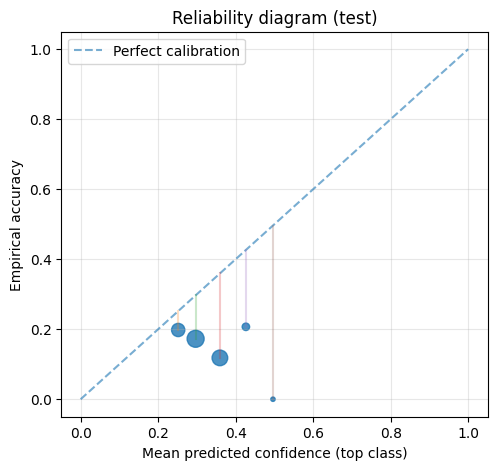

ECE (test): 0.150


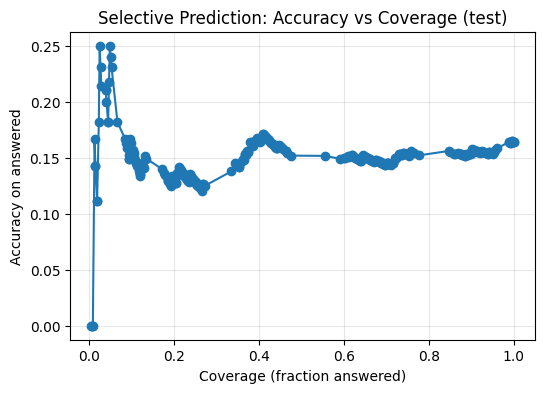

In [148]:
# ==== Accuracy, Reliability Diagram, and Selective Prediction (N-choice) ====

import numpy as np
import matplotlib.pyplot as plt

# 1) Helper: collect labels from a loader in the same order as predict_proba_mc concatenation
@torch.no_grad()
def collect_labels(dataloader):
    ys = []
    for _, _, _, gold in dataloader:
        ys.append(gold.detach().cpu().numpy())
    return np.concatenate(ys, axis=0)

# 2) Compute posterior predictive means for train/test
LAM = 1.0     # try 5.0 or 10.0 for tighter posteriors
S_MC = 30     # number of MC samples

p_tr = predict_proba_mc(train_loader, S=S_MC, lam=LAM)  # (N_tr, C)
p_te = predict_proba_mc(test_loader,  S=S_MC, lam=LAM)  # (N_te, C)

y_tr = collect_labels(train_loader).astype(int)
y_te = collect_labels(test_loader).astype(int)

# 3) Plain accuracy
def accuracy_from_probs(p, y):
    yhat = p.argmax(axis=1)
    return float((yhat == y).mean())

acc_tr = accuracy_from_probs(p_tr, y_tr)
acc_te = accuracy_from_probs(p_te, y_te)
print(f"Accuracy  train: {acc_tr:.3f} | test: {acc_te:.3f}")

# 4) Reliability diagram (top-class confidence vs empirical accuracy)
def reliability_points(p, y, n_bins=15):
    conf = p.max(axis=1)
    yhat = p.argmax(axis=1)
    correct = (yhat == y).astype(np.float32)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    mids, accs, confs, counts = [], [], [], []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        sel = (conf >= lo) & (conf < hi) if i < n_bins-1 else (conf >= lo) & (conf <= hi)
        if sel.any():
            mids.append(0.5*(lo+hi))
            accs.append(correct[sel].mean())
            confs.append(conf[sel].mean())
            counts.append(sel.sum())
    return np.array(mids), np.array(accs), np.array(confs), np.array(counts)

mids_te, accs_te, confs_te, cnts_te = reliability_points(p_te, y_te, n_bins=15)

plt.figure(figsize=(5.5,5))
plt.plot([0,1], [0,1], '--', alpha=0.6, label="Perfect calibration")
plt.scatter(confs_te, accs_te, s=np.clip(cnts_te, 10, 150), alpha=0.8)
for c,a in zip(confs_te, accs_te):
    plt.plot([c,c],[c,a], alpha=0.25)  # calibration error per bin
plt.xlabel("Mean predicted confidence (top class)")
plt.ylabel("Empirical accuracy")
plt.title("Reliability diagram (test)")
plt.grid(True, alpha=0.3)
plt.legend(); plt.show()

# Optional: Expected Calibration Error (ECE)
def expected_calibration_error(p, y, n_bins=15):
    conf = p.max(axis=1)
    yhat = p.argmax(axis=1)
    correct = (yhat == y).astype(np.float32)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    N = len(y)
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        sel = (conf >= lo) & (conf < hi) if i < n_bins-1 else (conf >= lo) & (conf <= hi)
        if sel.any():
            gap = abs(correct[sel].mean() - conf[sel].mean())
            ece += (sel.sum()/N) * gap
    return float(ece)

ece_te = expected_calibration_error(p_te, y_te, n_bins=15)
print(f"ECE (test): {ece_te:.3f}")

# 5) Selective prediction: accuracy vs coverage
def evaluate_with_abstention(probs, y_true, tau=0.5):
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)
    answered = conf >= tau
    coverage = answered.mean()
    acc = float("nan") if coverage == 0 else (pred[answered] == y_true[answered]).mean()
    return coverage, acc

# Adaptive thresholds from the data (ensures non-empty curve)
conf_te = p_te.max(axis=1)
taus = np.r_[0.0, np.sort(np.unique(np.round(conf_te, 4))), 0.999]

cov_acc = np.array([evaluate_with_abstention(p_te, y_te, tau=t) for t in taus])
coverages, accs = cov_acc[:,0], cov_acc[:,1]
mask = ~np.isnan(accs)

plt.figure(figsize=(6,4))
plt.plot(coverages[mask], accs[mask], marker="o")
plt.xlabel("Coverage (fraction answered)")
plt.ylabel("Accuracy on answered")
plt.title("Selective Prediction: Accuracy vs Coverage (test)")
plt.grid(True, alpha=0.3)
plt.show()


## 9) Per‑question posterior predictive (mean ± 1σ) with markers


In [128]:
@torch.no_grad()
def posterior_samples_for_loader(dataloader, S=30, lam=1.0):
    base_lora.eval(); head.eval()
    var = 1.0 / (lam * F_diag); std = var.sqrt()
    theta0 = pack(trainable)
    all_P = []
    for _ in range(S):
        theta_s = theta_map + torch.randn_like(std) * std
        set_params_from_vector(theta_s)
        probs_batches = []
        for enc, map_idx, opt_pos, gold in dataloader:
            out = base_lora(
                input_ids=enc.get("input_ids"),
                attention_mask=enc.get("attention_mask"),
                token_type_ids=enc.get("token_type_ids"),
            )
            scores_flat = forward_scores(out, head, attn_mask=enc.get("attention_mask"))
            N = gold.shape[0]
            C = int(opt_pos.max().item()) + 1
            scoresC = regroup_scores(scores_flat, map_idx, opt_pos, N, C)
            p = torch.softmax(scoresC, dim=1)
            probs_batches.append(p.detach().cpu().numpy())
        all_P.append(np.concatenate(probs_batches, axis=0))
    set_params_from_vector(theta0)
    return np.stack(all_P, axis=0)  # (S, N, C)

In [129]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt

def plot_single_event(mean, std, y_true=None, class_names=None, entry_id=None):
    C = mean.shape[0]
    xs = np.arange(C)
    labels = class_names if class_names is not None else [chr(ord('A')+i) for i in range(C)]
    plt.errorbar(xs, mean, yerr=std, fmt="none", ecolor="k", capsize=5)
    plt.plot(xs, mean, "o", color="k", markersize=6)
    y_pred = int(mean.argmax())
    plt.plot(xs[y_pred], mean[y_pred], "o", color="blue", markersize=10)
    if y_true is not None:
        plt.plot(xs[y_true], mean[y_true], marker="*", color="red", markersize=14)
    plt.xticks(xs, labels); plt.ylim(0,1); plt.ylabel("Probability"); plt.xlabel("Category")
    plt.title(f"Posterior for entry {entry_id}" if entry_id is not None else "Posterior (single question)")
    legend_elements = [
        Line2D([0],[0], marker="o", color="k",   linestyle="none", markersize=6,  label="Posterior (mean ± 1σ)"),
        Line2D([0],[0], marker="o", color="blue",linestyle="none", markersize=10, label="Predicted"),
        Line2D([0],[0], marker="*", color="red", linestyle="none", markersize=14, label="True"),
    ]
    plt.legend(handles=legend_elements, loc="best"); plt.grid(alpha=0.3); plt.show()


## 10) Notes & Next Steps

- **LoRA targets**: adjust `target_modules` depending on the backbone (e.g., `query`, `key`, `value`, `dense`, or specific module names in RoBERTa/DistilBERT).
- **λ (lam)**: try `0.1, 1.0, 5.0` to see how posterior width affects calibration/abstention.
- **Full Laplace libraries**: for research‑grade Laplace, consider `laplace-torch` (not used here to keep dependencies light).
- **Speed**: keep the model small (`bert-tiny`) and dataset tiny for quick iterations on CPU.
- **Ethical angle**: plot **accuracy vs coverage** and **reliability** to illustrate “knowing when not to answer” after Bayesianizing the LoRA adapters.
